In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [3]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_PARKIR.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2007-1,11379000,2007-01-01
1,2007-2,11379000,2007-02-01
2,2007-3,10275500,2007-03-01
3,2007-4,12179700,2007-04-01
4,2007-5,11934400,2007-05-01


In [4]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/parkir.json', 'w') as f:
    json.dump(json_data, f) 

{"2007-01-01T00:00:00.000":11379000,"2007-02-01T00:00:00.000":11379000,"2007-03-01T00:00:00.000":10275500,"2007-04-01T00:00:00.000":12179700,"2007-05-01T00:00:00.000":11934400,"2007-06-01T00:00:00.000":12463900,"2007-07-01T00:00:00.000":13206100,"2007-08-01T00:00:00.000":13367500,"2007-09-01T00:00:00.000":12343800,"2007-10-01T00:00:00.000":15261900,"2007-11-01T00:00:00.000":18015200,"2007-12-01T00:00:00.000":10997500,"2008-01-01T00:00:00.000":13618800,"2008-02-01T00:00:00.000":13663400,"2008-03-01T00:00:00.000":13869500,"2008-04-01T00:00:00.000":15437900,"2008-05-01T00:00:00.000":15470900,"2008-06-01T00:00:00.000":12708100,"2008-07-01T00:00:00.000":19133500,"2008-08-01T00:00:00.000":16016300,"2008-09-01T00:00:00.000":13991600,"2008-10-01T00:00:00.000":25153200,"2008-11-01T00:00:00.000":19673700,"2008-12-01T00:00:00.000":26844300,"2009-01-01T00:00:00.000":616400,"2009-02-01T00:00:00.000":23174100,"2009-03-01T00:00:00.000":15031500,"2009-04-01T00:00:00.000":17578100,"2009-05-01T00:00:00.

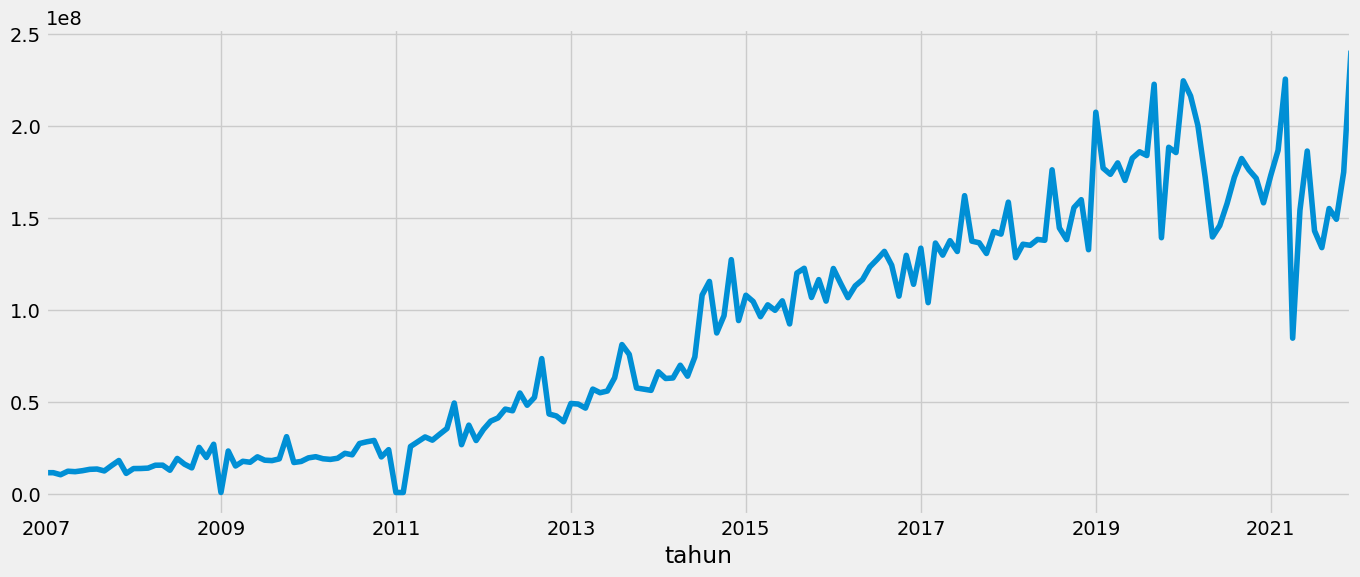

In [5]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [4]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [5]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit()
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
print('\nBest Result:', best_result)


Best Result: [(0, 1, 1), (0, 1, 1, 12), 6072.9188032007205]


In [ ]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(1, 1, 0),seasonal_order=(1, 1, 0, 12),
                            enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -2819.513
Date:                            Wed, 28 Dec 2022   AIC                           5645.025
Time:                                    08:12:59   BIC                           5654.136
Sample:                                01-01-2007   HQIC                          5648.726
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4211      0.049     -8.590      0.000      -0.517      -0.325
ar.S.L12      -0.4817      0.075   

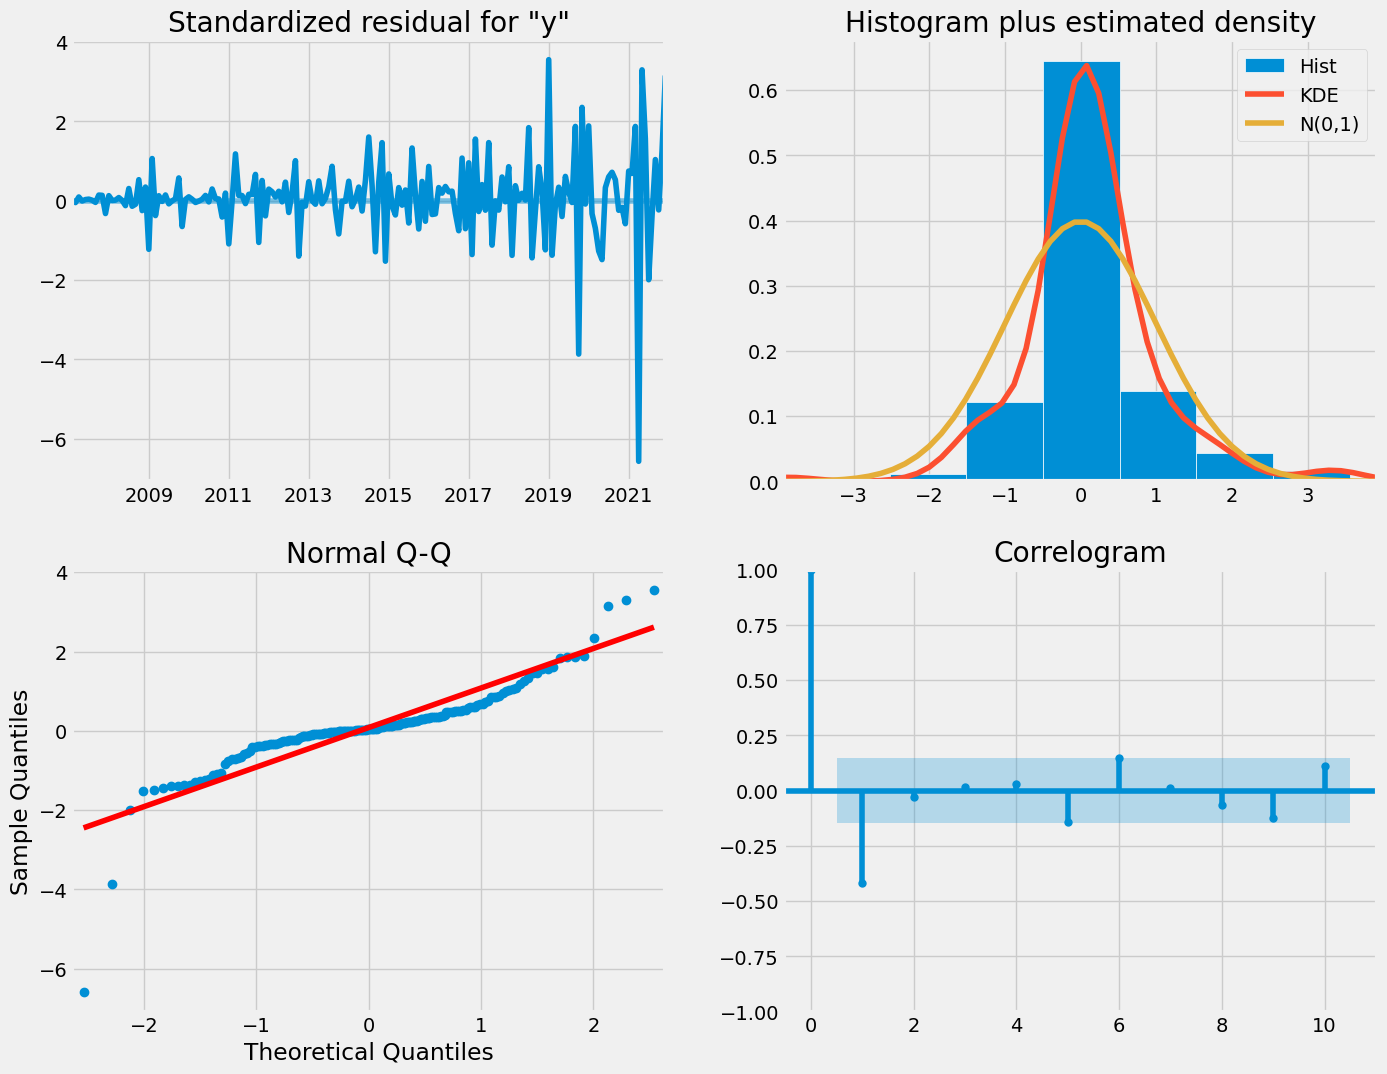

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

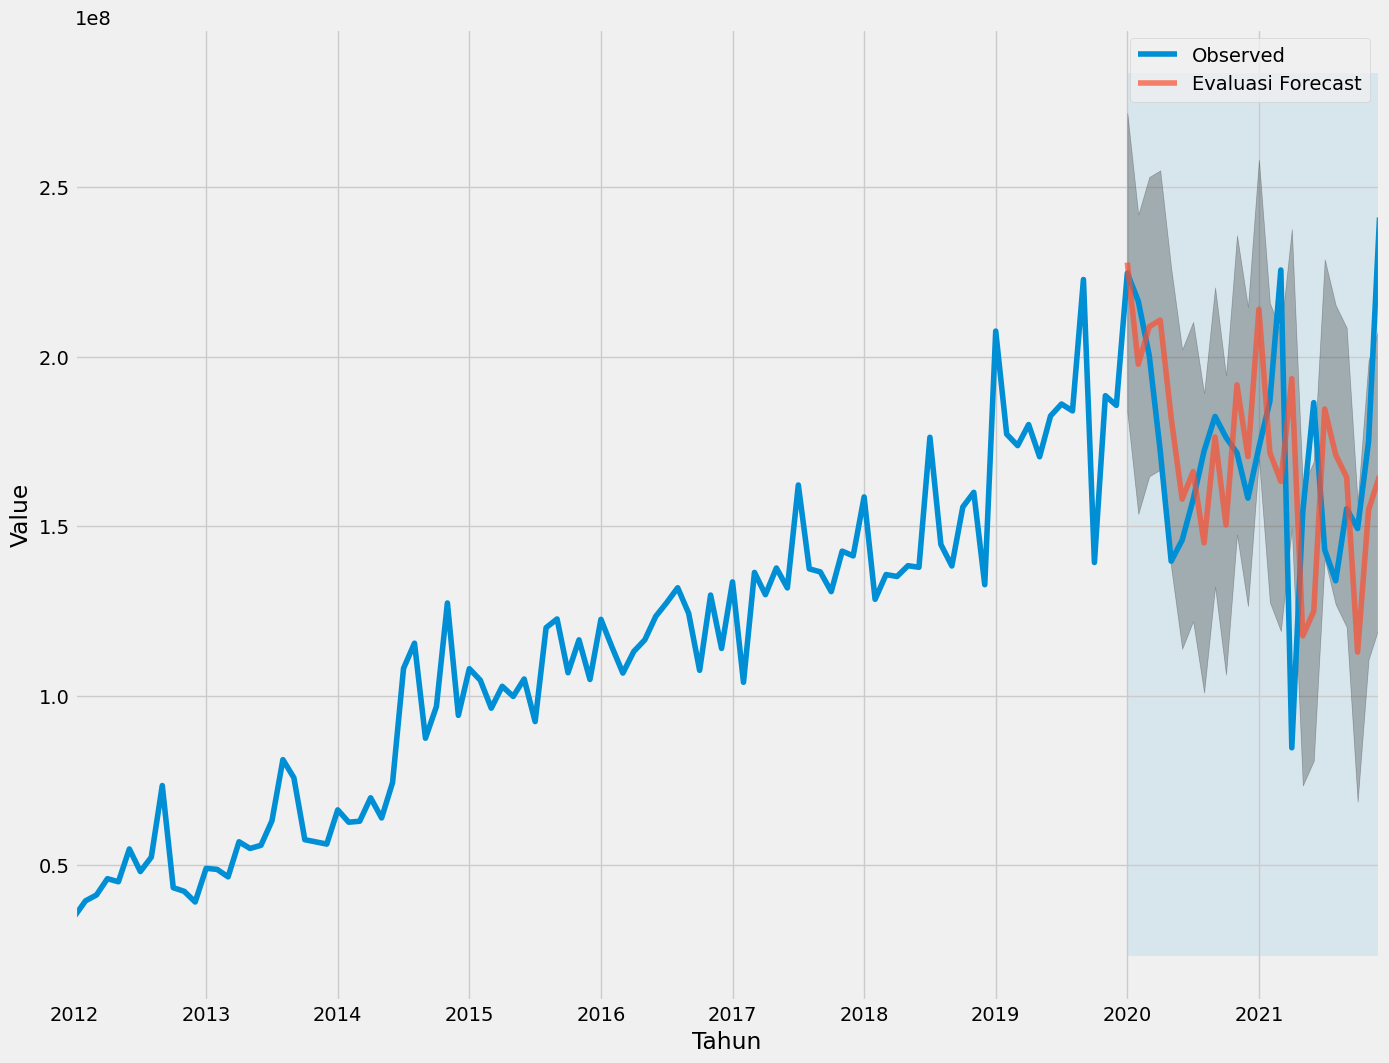

In [7]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

# Prediksi data selama 2 tahun

In [10]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=60, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()


json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/parkir_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":236242641.713301003,"2022-02-01T00:00:00.000":252500804.3703357279,"2022-03-01T00:00:00.000":259306199.1608420014,"2022-04-01T00:00:00.000":175054898.6975184977,"2022-05-01T00:00:00.000":194465514.8093449473,"2022-06-01T00:00:00.000":214556752.9300398827,"2022-07-01T00:00:00.000":197633164.070204854,"2022-08-01T00:00:00.000":199870808.0562958717,"2022-09-01T00:00:00.000":215782331.4840854406,"2022-10-01T00:00:00.000":209790578.6180105805,"2022-11-01T00:00:00.000":220881410.8255078793,"2022-12-01T00:00:00.000":248696982.6893812418,"2023-01-01T00:00:00.000":253440616.9955942035,"2023-02-01T00:00:00.000":268419333.9594838917,"2023-03-01T00:00:00.000":290601954.2893399,"2023-04-01T00:00:00.000":179045047.7505190074,"2023-05-01T00:00:00.000":222640748.5882130861,"2023-06-01T00:00:00.000":248563015.5820146203,"2023-07-01T00:00:00.000":218876231.8388380706,"2023-08-01T00:00:00.000":215633094.5883835852,"2023-09-01T00:00:00.000":234121947.7595428824,"2023-10-01T00:00

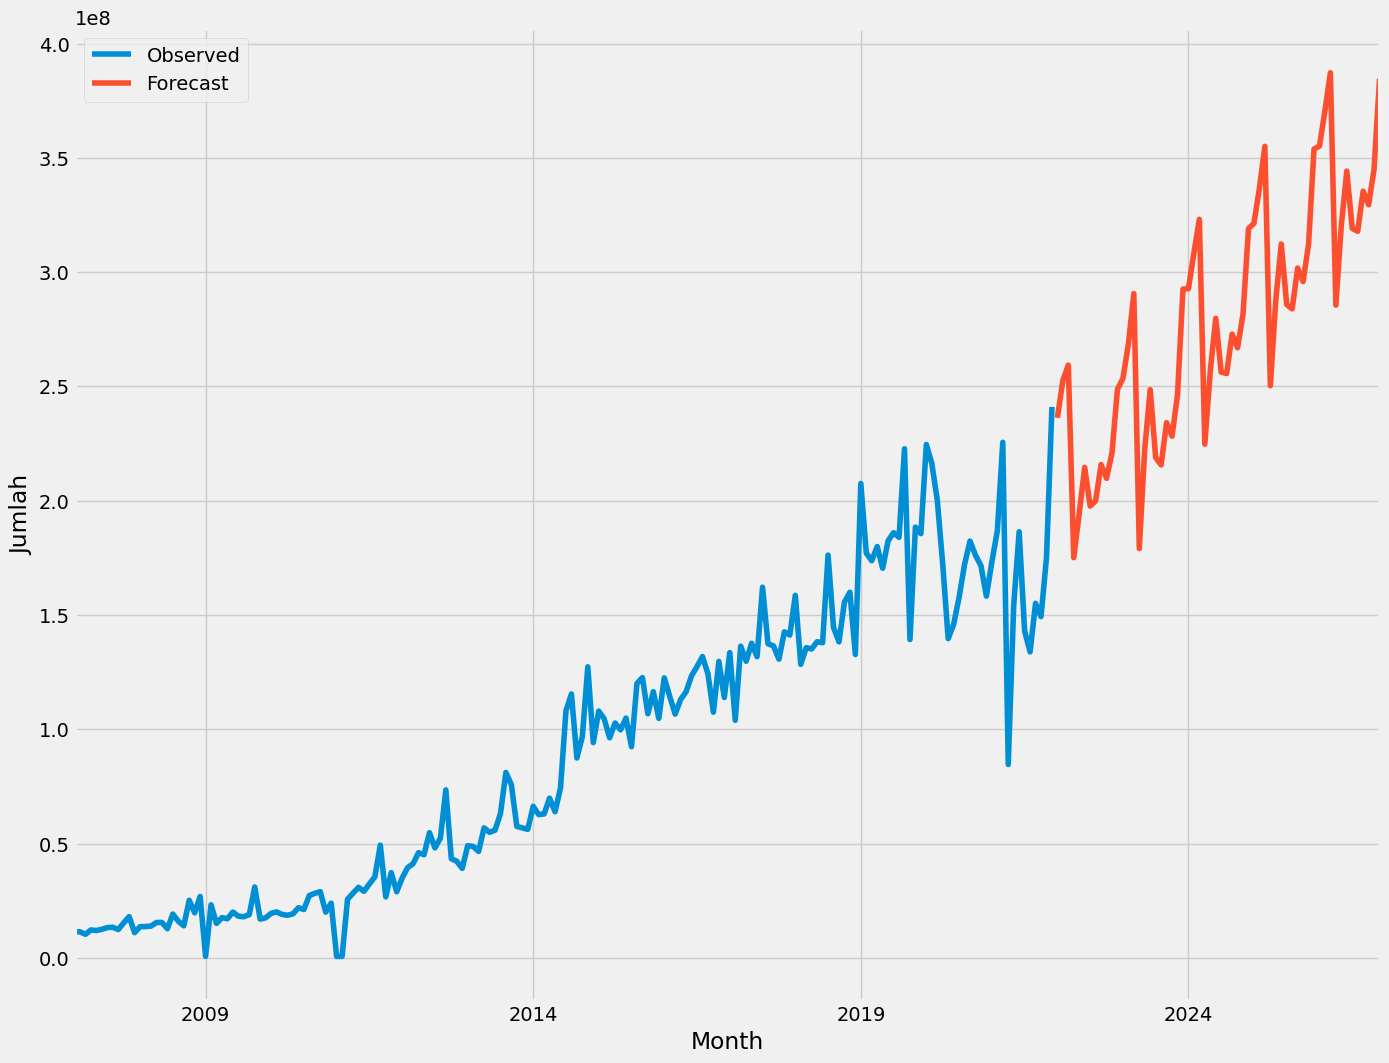

In [11]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()